## Compute Sagnac Frequency - Backscatter Correction - Time Domain Values

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# from matplotlib import rc
# rc('text', usetex=True)

## Configurations

In [4]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-09-19 00:00")
config['tend'] = UTCDateTime("2023-09-19 10:00")

# config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

config['path_to_data'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [5]:
def __compute_psd(st0, twin_sec=60):

    from scipy.signal import welch, hann

    _st = st0.copy()

    _st.sort(keys=['channel'], reverse=True)

    nblock = int(st0[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(_st):

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win, noverlap=overlap,
                        nfft=nblock,
                        scaling="spectrum",
                        return_onesided=True)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

    out = {}
    out['Pxxs'] = Pxxs
    out['ffs'] = ffs
    out['chs'] = chs

    return out

In [6]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

In [7]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    year = str(tbeg.year)

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{year}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

## Load data

In [8]:
beat = __load_beat(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

In [9]:
beat

,times_utc,times_utc_sec,times_mjd,fj,f1,f2,pz,p1,p2,ac_z,ac_1,ac_2,dc_z,dc_1,dc_2,contrast_z,contrast_1,contrast_2
3,2023-09-19T00:00:30.000000Z,30.0,60206.000347,303.060513,303.060378,303.060363,0.078252,0.007249,0.003142,0.174921,0.030303,0.028539,0.098042,0.417102,0.407499,0.886027,0.036310,0.035011
4,2023-09-19T00:01:30.000000Z,90.0,60206.001042,303.060584,303.060446,303.060433,0.078278,0.007224,0.003164,0.174980,0.030219,0.028462,0.098062,0.417118,0.407515,0.886125,0.036207,0.034915
5,2023-09-19T00:02:30.000000Z,150.0,60206.001736,303.060618,303.060513,303.060433,0.078318,0.007201,0.003178,0.175060,0.030205,0.028617,0.098121,0.417118,0.407612,0.886048,0.036191,0.035098
6,2023-09-19T00:03:30.000000Z,210.0,60206.002431,303.060455,303.060349,303.060374,0.078368,0.007188,0.003187,0.175155,0.030263,0.028902,0.098141,0.417135,0.407736,0.886349,0.036258,0.035437
7,2023-09-19T00:04:30.000000Z,270.0,60206.003125,303.060274,303.060200,303.060143,0.078422,0.007179,0.003191,0.175278,0.030406,0.029300,0.098193,0.417128,0.407988,0.886500,0.036430,0.035903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,2023-09-19T09:55:30.000000Z,35730.0,60206.413542,303.016470,303.016589,303.016543,0.090960,0.006190,0.003301,0.203127,0.027728,0.030246,0.120054,0.444327,0.480949,0.840934,0.031192,0.031439
599,2023-09-19T09:56:30.000000Z,35790.0,60206.414236,303.016519,303.016560,303.016513,0.090972,0.006192,0.003305,0.203115,0.027199,0.029324,0.120050,0.444356,0.480734,0.841005,0.030596,0.030497
600,2023-09-19T09:57:30.000000Z,35850.0,60206.414931,303.016348,303.016417,303.016368,0.090976,0.006194,0.003309,0.203087,0.026655,0.028273,0.120039,0.444386,0.480538,0.841024,0.029983,0.029419
601,2023-09-19T09:58:30.000000Z,35910.0,60206.415625,303.016319,303.016383,303.016314,0.090972,0.006195,0.003309,0.203044,0.026500,0.028312,0.120019,0.444403,0.480364,0.841066,0.029808,0.029468


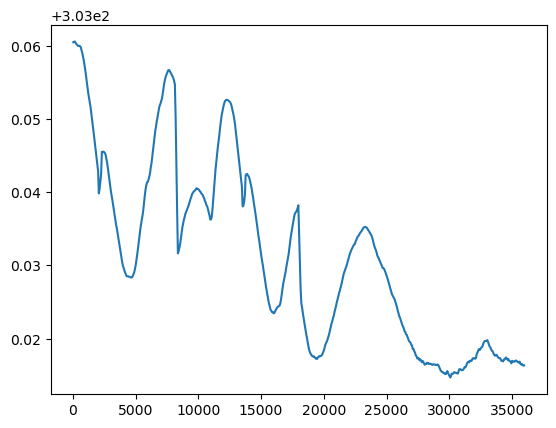

In [10]:
plt.plot(beat.times_utc_sec, beat.fj)

## Define quantities

In [33]:
# fractional beat modulations
m01 = beat.ac_1 / beat.dc_1
m02 = beat.ac_1 / beat.dc_2

# phase difference
# phase0 = abs(hilbert(beat.f1 - beat.f2))
phase0 = m01 - m02

# beat signal observered
w_obs = beat.fj


## from Hurst 2014

## free spectral range fsr = c / P
fL = 8e6 ## Hz

## gain
alpha = 7.39e-6

## sekf-saturation coefficient
beta = 4.67e-5

## cross-saturation coefficient
theta = 1.014e-5

I0 = beat.ac_z + beat.dc_z

## Correct for bias

In [34]:
m1 = m01 * ( 1 + m01**2 / 4 )
m2 = m02 * ( 1 + m02**2 / 4 )

## Angular correction for phase

In [35]:
phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

## Compute squares of the common-mode and differential-mode modulations

In [55]:
m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4
m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

## Correct m2c for gain saturation for a He-Ne laser

In [56]:
# m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )

## Compute M as BS correction

In [38]:
M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2
# plt.plot(M)

## Beat Correction

In [40]:
w_s = w_obs * ( 4 + M ) / ( 4 - M )

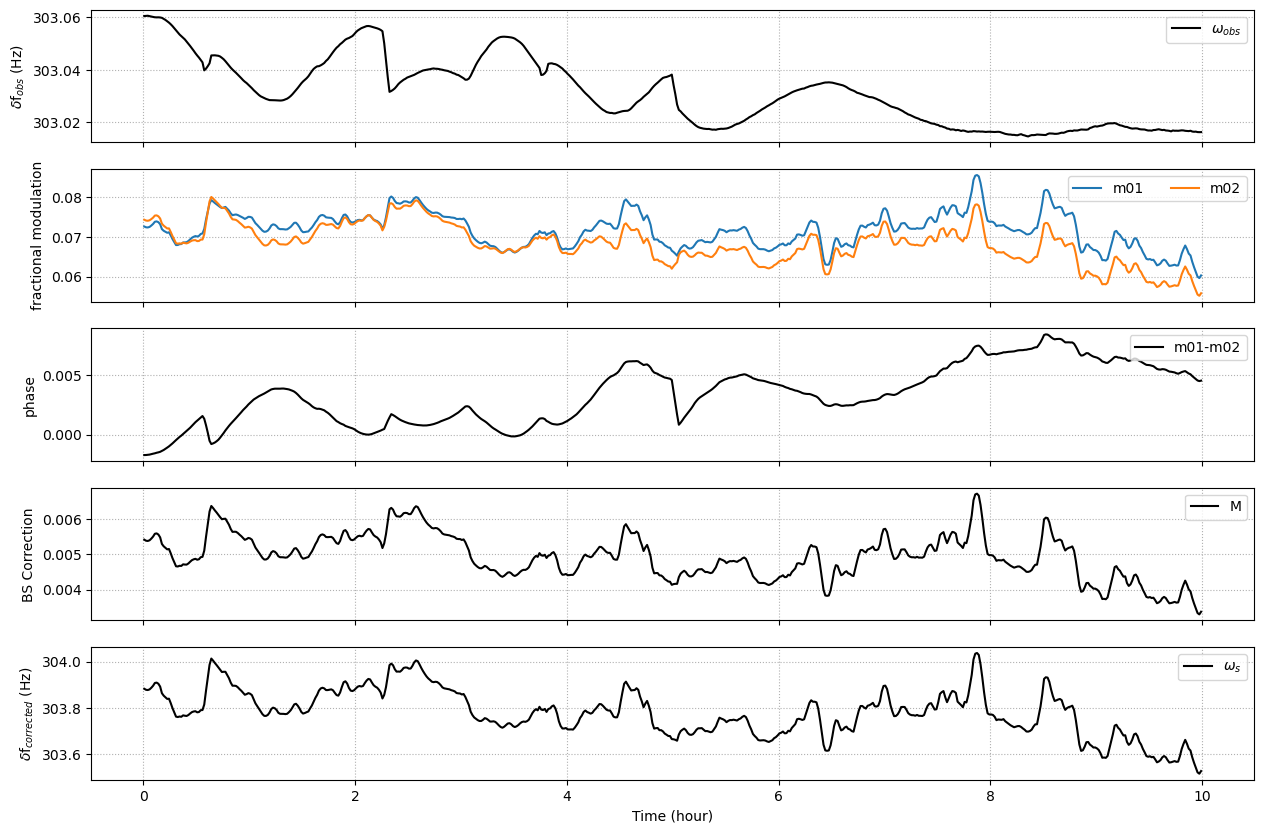

In [58]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = beat.times_utc_sec/3600

    ax[0].plot(t_axis, w_obs, color="k", label="$\omega_{obs}$")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f$_{obs}$ (Hz)")

    ax[1].plot(t_axis, m01, label="m01")
    ax[1].plot(t_axis, m02, label="m02")
    ax[1].set_ylabel("fractional modulation")

    ax[2].plot(t_axis, phase, color="k", label="m01-m02")
    ax[2].set_ylabel("phase")

    ax[3].plot(t_axis, M, color="k", label="M")
    ax[3].set_ylabel("BS Correction")

    ax[4].plot(t_axis, w_s, color="k", label="$\omega_{s}$")
    ax[4].set_ylabel("$\delta$f$_{corrected}$ (Hz)")

    ax[4].set_xlabel("Time (hour)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_timedomain.png", format="png", dpi=200, bbox_inches='tight')

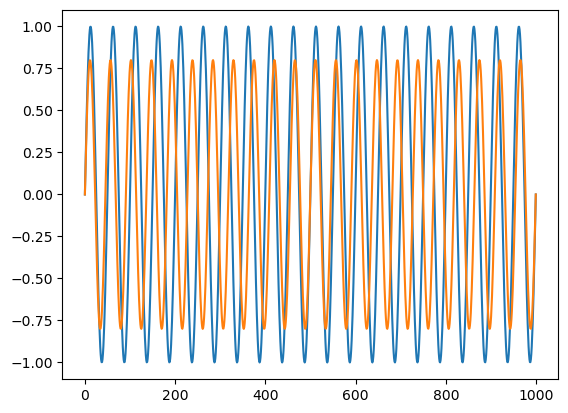

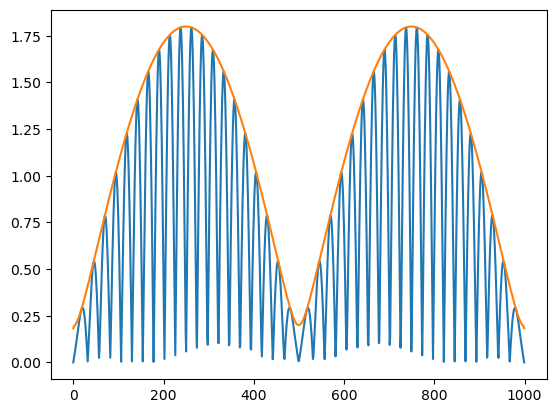

In [42]:
t = np.linspace(0, 20, 1000)

a = 1.0 * np.sin(2*np.pi*1*t)
b = 0.8 * np.sin(2*np.pi*1.1*t)

plt.figure()
plt.plot(a)
plt.plot(b)

plt.figure()
plt.plot(abs((a-b)))
plt.plot(abs(hilbert(a-b)))


## Plot Comparison